# Tabular Playground Series - Apr 2022

In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence.

### Setup

In [34]:
%%capture

from typing import Tuple

from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
sns.set(rc = {'figure.figsize':(10, 6)})

from ml_utils.preprocess.pipeline import preprocessing_pipeline

### Load data

In [27]:
pipeline = {}

train = pd.read_csv("Data/train.csv")
train_labels = pd.read_csv("Data/train_labels.csv")
train = pd.merge(train, train_labels, on="sequence")

test = pd.read_csv("Data/test.csv")

train.drop(['sequence'], axis=1, inplace=True)
test.drop(['subject'], axis=1, inplace=True)

print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

Train shape (1558080, 16)
Test shape (733080, 15)


In [3]:
train.head()

,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


### EDA

Feature distributions

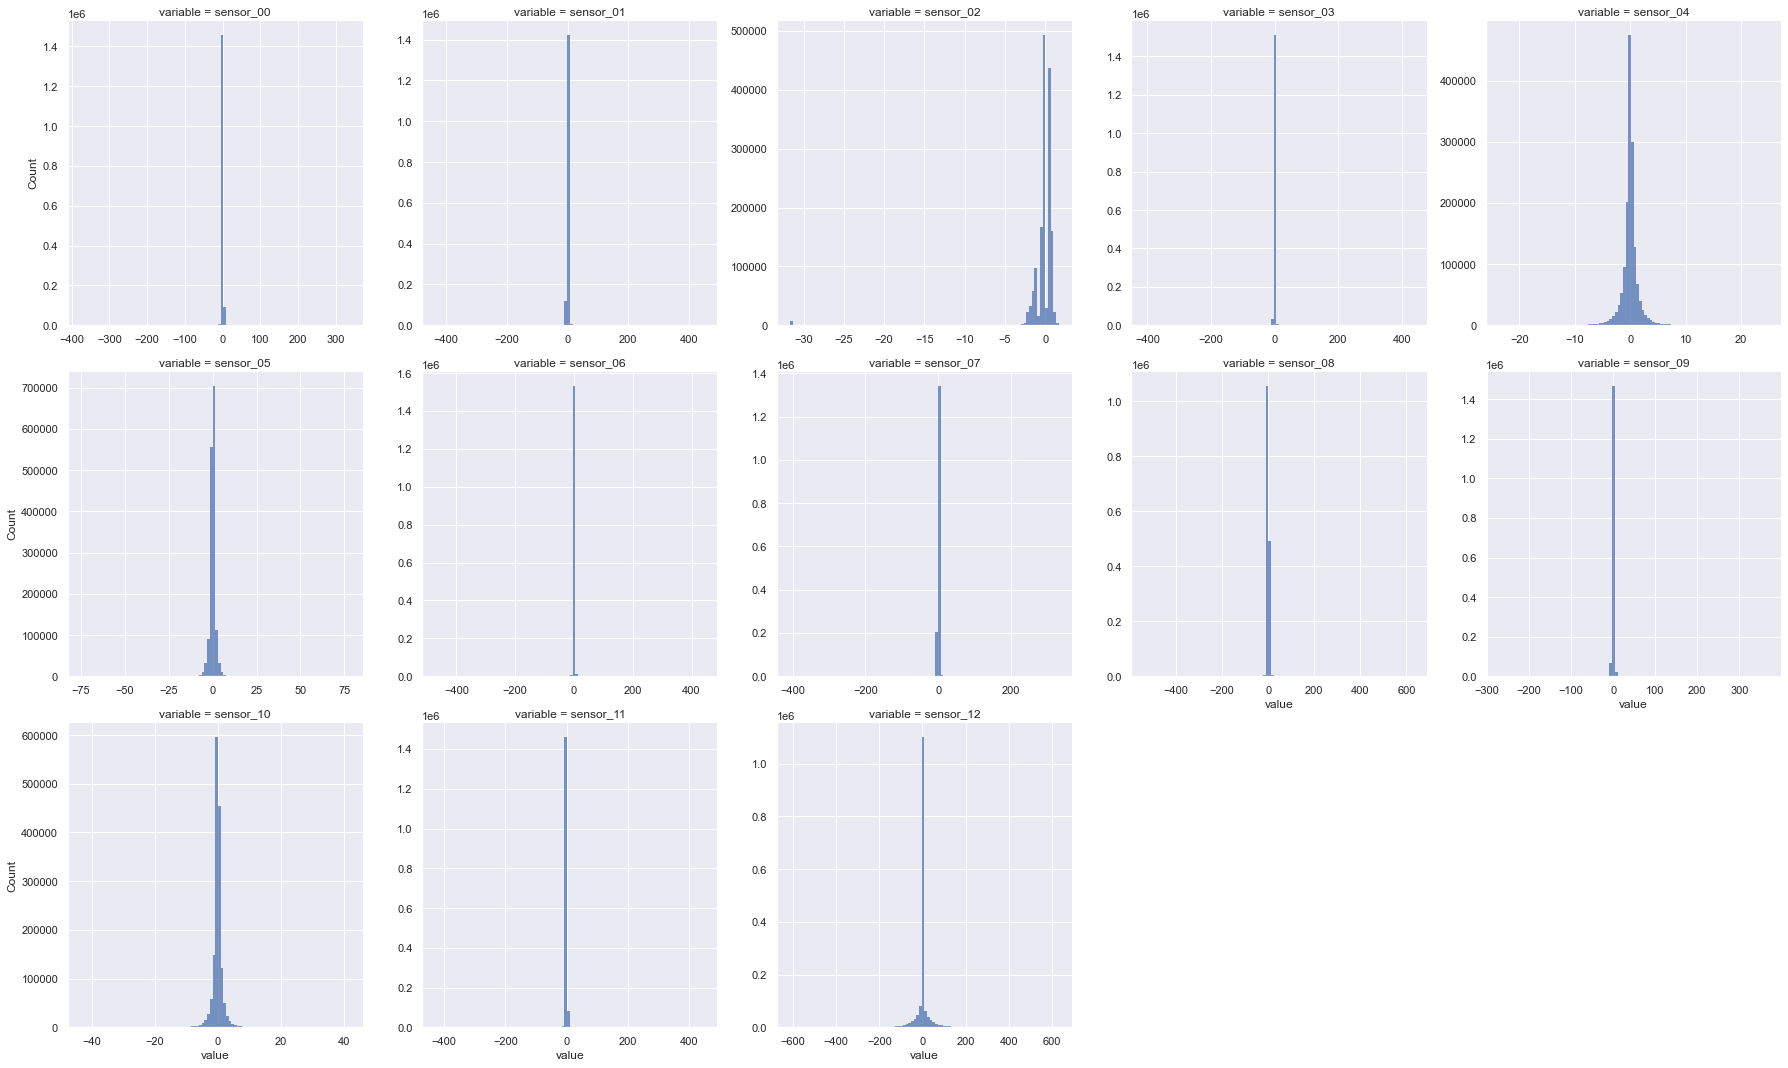

In [4]:
sensor_cols = [x for x in train.columns if 'sensor' in x]

sns.displot(
    data=pd.melt(train[sensor_cols]),
    x="value",
    col="variable",
    bins=100,
    col_wrap=5,
    common_bins=False,
    facet_kws=dict(
        sharex=False,
        sharey=False,
    )
)

There is no missing data

### Base model

In [77]:
model = LGBMClassifier(max_depth=10)

def stratify_train_test(df) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Get test/train split based on subjects
    """
    # Simple test/train split based on subject
    subjects_shuffled = np.random.permutation(df['subject'].unique())

    train_cutoff = int(np.floor(len(subjects_shuffled) * 0.8))

    train_subjects = subjects_shuffled[:train_cutoff]
    test_subjects = subjects_shuffled[train_cutoff:]

    train = df[df.subject.isin(train_subjects)].drop('subject', axis=1)
    test = df[df.subject.isin(test_subjects)].drop('subject', axis=1)

    return train, test

stratified_train, stratified_test = stratify_train_test(train)

X_train, y_train = stratified_train.drop('state', axis=1), stratified_train['state']
X_test, y_test = stratified_test.drop('state', axis=1), stratified_test['state']

In [18]:
%%time

model.fit(X_train,y_train)
y_hat = model.predict_proba(X_test)[:, 1]

CPU times: total: 51.3 s
Wall time: 3.55 s


In [82]:
roc_auc_score(y_test, y_hat)

ValueError: Found input variables with inconsistent numbers of samples: [333300, 733080]

In [ ]:
from ml_utils.visualise.features import plot_importances

plot_importances(model, X_train.columns, 20)

### Train final model

In [78]:
N_CV = 5

kfold = KFold(n_splits=N_CV)

train_score = []
valid_score = []
test_set_preds = []

X, y = train.drop('state', axis=1), train['state']

subjects_shuffled = np.random.permutation(train['subject'].unique())

# KFolds split by unique
for fold, (train_subj, valid_subj) in enumerate(kfold.split(subjects_shuffled)):
    print(f"Running fold: {fold}...")

    train_fold = train[train['subject'].isin(train_subj)].drop(['subject'], axis=1)
    valid_fold = train[train['subject'].isin(valid_subj)].drop(['subject'], axis=1)

    X_train, y_train = train_fold.drop('state', axis=1), train_fold['state']
    X_valid, y_valid = valid_fold.drop('state', axis=1), valid_fold['state']

    model.fit(X_train, y_train)

    y_hat_train = model.predict_proba(X_train)[:, 1]
    y_hat_test = model.predict_proba(X_valid)[:, 1]

    train_score.append(roc_auc_score(y_train, y_hat_train))
    valid_score.append(roc_auc_score(y_valid, y_hat_test))

    # Fold prediction on test set
    y_hat = model.predict_proba(test.drop('sequence', axis=1))[:,1]
    test_set_preds.append(y_hat)

Running fold: 0...
Running fold: 1...
Running fold: 2...
Running fold: 3...
Running fold: 4...


Mean train score 0.6460610592406992
Mean test score 0.6095801778847416


<AxesSubplot:xlabel='fold', ylabel='accuracy'>

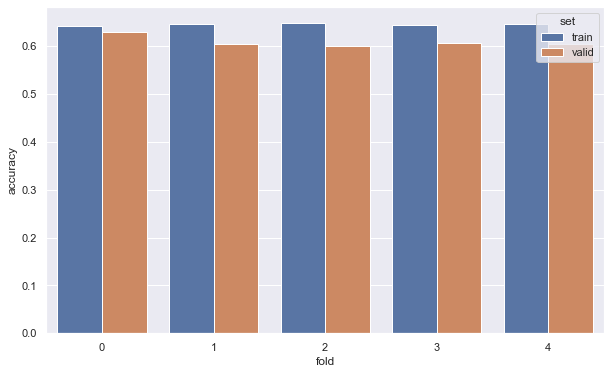

In [79]:
results_df = pd.DataFrame({
    "fold": list(range(N_CV)),
    "train": train_score,
    "valid": valid_score
})
results_df = pd.melt(results_df, id_vars="fold", var_name="set",value_name="accuracy")
print(f"Mean train score {np.mean(train_score)}")
print(f"Mean test score {np.mean(valid_score)}")
sns.barplot(data=results_df, x="fold", y="accuracy", hue="set")

### Submission

In [80]:
submission = test[['sequence']].copy()
submission['sequence'] = submission['sequence'].astype(int)
submission["state"] = np.mean(test_set_preds, axis=0)
submission = submission.groupby('sequence')['state'].max().reset_index()
submission.to_csv('Data/test_preds.csv', index=False)